<a href="https://colab.research.google.com/github/peteray-dev/GAN_Painter/blob/master/CYCLEGAN_I_AM_SOMETHING_OF_A_PAINTER_MYSELF_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Translating a generated image into a real image using GAN**

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


In [2]:

!kaggle competitions download gan-getting-started


 98% 361M/367M [00:04<00:00, 74.9MB/s]
100% 367M/367M [00:05<00:00, 76.5MB/s]


In [3]:
!mkdir gan-getting-started.zip

!mv /content/gan-getting-started.zip* /content/gan-getting-started

mkdir: cannot create directory ‘gan-getting-started.zip’: File exists


 **GAN PROCESS**

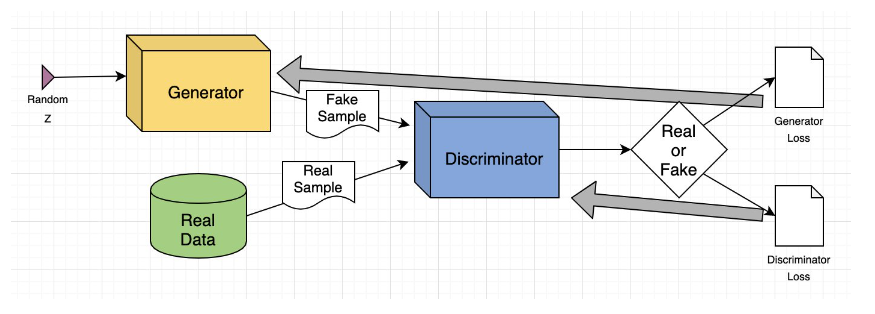

In [4]:
! unzip "/content/gan-getting-started"

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391d94b.jpg  
  inflating: photo_jpg/47df26

In [5]:
# Import necessary packages.
import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset, Dataset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms


# This is for the progress bar.
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir) if img_name.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Example usage
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

monet_dataset = CustomImageDataset(img_dir="/content/monet_jpg", transform=transform)
photo_dataset = CustomImageDataset(img_dir="/content/photo_jpg", transform=transform)

In [8]:
monet_dataset[0].shape

torch.Size([3, 256, 256])

In [9]:
print(f"Monet dataset: {len(monet_dataset)}")
print(f"photo dataset: {len(photo_dataset)}")

Monet dataset: 300
photo dataset: 7038


In [10]:
monet_loader = DataLoader(monet_dataset, batch_size=32, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=32, shuffle=True)

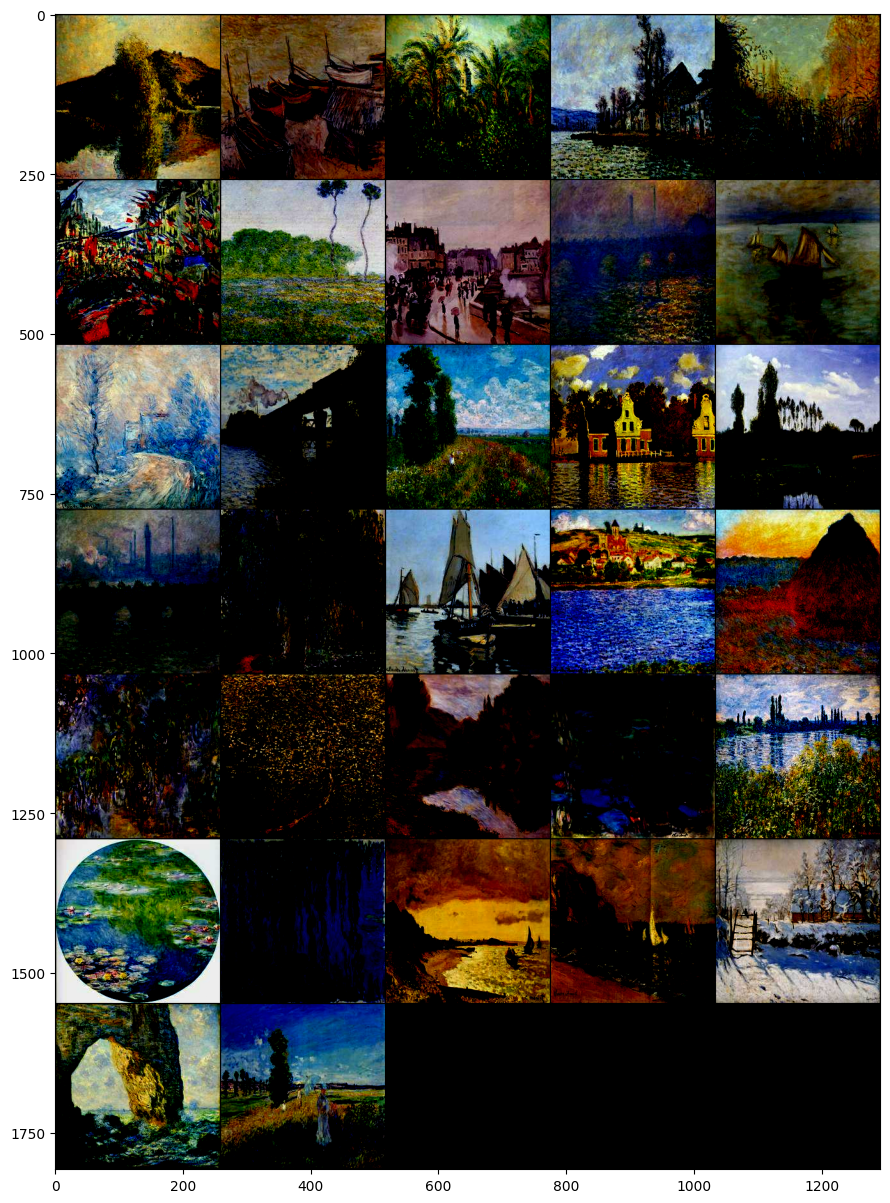

In [11]:
def show_image(image, title=None):
    """Show image with title if provided."""
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)
# Get a batch of training data
data_iter = iter(monet_loader)
images = next(data_iter)

# Make a grid from batch
out = torchvision.utils.make_grid(images, nrow=5)

# Display the images
plt.figure(figsize=(15, 15))  # Adjust figure size as needed
show_image(out)
plt.show()


In [12]:
shape = cv2.imread('/content/monet_jpg/011835cfbf.jpg').shape
shape

(256, 256, 3)

## Model Building

Generator (Upsampling)

In [65]:

class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, feature_maps_g):
        super(Generator, self).__init__()

        self.init_size = 32  # Initial size before upsampling
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, feature_maps_g * 8 * self.init_size * self.init_size)
        )

        self.deconv_layers = nn.Sequential(
            nn.BatchNorm2d(feature_maps_g * 8),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps_g * 8, feature_maps_g * 4, 3, stride=1, padding=1),
            nn.BatchNorm2d(feature_maps_g * 4),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps_g * 4, feature_maps_g * 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(feature_maps_g * 2),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps_g * 2, feature_maps_g, 3, stride=1, padding=1),
            nn.BatchNorm2d(feature_maps_g),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps_g, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), -1, self.init_size, self.init_size) #(batch_size =32, feature_maps_g * 8=256, 16, 16)
        img = self.deconv_layers(out)
        return img

latent_dim = 100
img_channels = 3
feature_maps_g = 32

gen = Generator(latent_dim, img_channels, feature_maps_g)
print(gen)


Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=262144, bias=True)
  )
  (deconv_layers): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Upsample(scale_factor=2.0, mode='nearest')
    (10): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Upsample(scale_factor=2.0, mod

Discriminator (Downsampling)

In [66]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_maps_d):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps_d, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_d, feature_maps_d * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps_d * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_d * 2, feature_maps_d * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps_d * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_d * 4, feature_maps_d * 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps_d * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_d * 8, 1, 4, stride=1, padding=0),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Sigmoid()
        )


    def forward(self, img):
        validity = self.conv_layers(img)
        return validity.view(img.size(0), -1)

img_channels = 3
feature_maps_d = 32

disc = Discriminator(img_channels, feature_maps_d)
print(disc)


Discriminator(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
    (13): Sigmoid()
  )
)


In [67]:
photo = next(iter(photo_loader))
photo[0].shape

torch.Size([3, 256, 256])

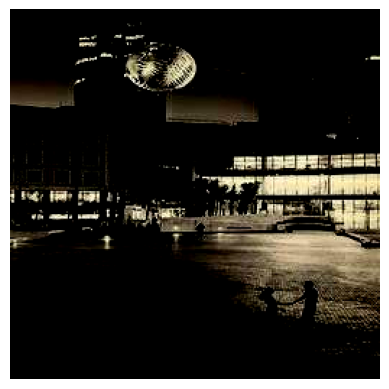

In [68]:
import matplotlib.pyplot as plt

# Assuming `real_images` is your tensor
real_images = next(iter(photo_loader))

# Visualize the first image in the batch
plt.imshow(real_images[0].permute(1, 2, 0))  # since the images are in format (C, H, W)
plt.axis('off')  # Hide axes
plt.show()



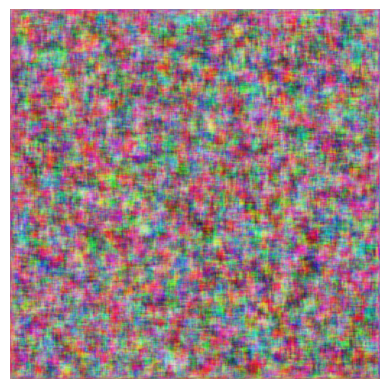

In [69]:



# Create the generator
latent_dim = 100
gen = Generator(latent_dim, 3, 64)

# Sample noise vector
noise_vector = torch.randn(1, latent_dim)

# Generate an image
with torch.no_grad():
    generated_image = gen(noise_vector)

def visualize_images(generated_imgs):
    """
    Visualizes the generated images.
    """
    # Assume the image is in range [-1, 1], convert to [0, 1]
    img = (generated_imgs.squeeze(0).permute(1, 2, 0) + 1) / 2
    img = img.cpu().numpy()
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Visualize the generated image
visualize_images(generated_image)


In [70]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

GPU is available
GPU Device Name: Tesla T4


In [71]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"



In [72]:
gen_photo_to_monet = Generator(latent_dim, img_channels, feature_maps_g)
gen_monet_to_photo = Generator(latent_dim, img_channels, feature_maps_g)
disc_photo = Discriminator(img_channels, feature_maps_d)
disc_monet = Discriminator(img_channels, feature_maps_d)

gen_photo_to_monet.to(device)
gen_monet_to_photo.to(device)
disc_photo.to(device)
disc_monet.to(device)

Discriminator(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
    (13): Sigmoid()
  )
)

In [38]:
# Initialize a model, and put it on the device specified.
# gen = Generator(latent_dim, img_channels, feature_maps_g)
# dis = Discriminator(img_channels, feature_maps_d)
# gen = gen.to(device)
# dis = dis.to(device)

### Optimizer and Loss

In [75]:
# Loss function
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(
    list(gen_photo_to_monet.parameters()) + list(gen_monet_to_photo.parameters()), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_photo = torch.optim.Adam(disc_photo.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_monet = torch.optim.Adam(disc_monet.parameters(), lr=2e-4, betas=(0.5, 0.999))



### Training

In [76]:
for data in photo_loader:
    print(data.size(0))  # Print the number of elements returned
    break

32


In [77]:
num_epochs = 100
# Training loop
g_loss_epoch = []
d_loss_photo_epoch = []
d_loss_monet_epoch = []
for epoch in range(num_epochs):
    g_loss_btch = []
    d_loss_photo_btch = []
    d_loss_monet_btch = []
    for i, real_photos in enumerate(tqdm(photo_loader)):
        real_monets = next(iter(monet_loader))

        real_photos = real_photos.to(device)
        real_monets = real_monets.to(device)

        # Adversarial ground truths
        valid = torch.ones(real_photos.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(real_photos.size(0), 1, requires_grad=False).to(device)

        # -----------------
        #  Train Generator
        # -----------------

       # Photo to Monet
        fake_monets = gen_photo_to_monet(real_photos)
        loss_GAN_photo_to_monet = adversarial_loss(disc_monet(fake_monets), valid)

        # Monet to Photo
        fake_photos = gen_monet_to_photo(real_monets)
        loss_GAN_monet_to_photo = adversarial_loss(disc_photo(fake_photos), valid)

        # Cycle consistency
        recovered_photos = gen_monet_to_photo(fake_monets)
        loss_cycle_photo = cycle_loss(recovered_photos, real_photos)

        recovered_monets = gen_photo_to_monet(fake_photos)
        loss_cycle_monet = cycle_loss(recovered_monets, real_monets)

        # Identity loss
        loss_identity_photo = identity_loss(gen_monet_to_photo(real_photos), real_photos)
        loss_identity_monet = identity_loss(gen_photo_to_monet(real_monets), real_monets)

        # Total loss
        loss_G = (loss_GAN_photo_to_monet + loss_GAN_monet_to_photo +
                  10.0 * (loss_cycle_photo + loss_cycle_monet) +
                  5.0 * (loss_identity_photo + loss_identity_monet))

        loss_G.backward()
        optimizer_G.step()

        g_loss_btch.append(loss_G.item())



        # ---------------------
        #  Train Discriminator
        # ---------------------



        # Measure discriminator's ability to classify real from generated samples
        optimizer_D_photo.zero_grad()
        optimizer_D_monet.zero_grad()

        # Discriminator for real and fake photos
        loss_real_photo = adversarial_loss(disc_photo(real_photos), valid)
        loss_fake_photo = adversarial_loss(disc_photo(fake_photos.detach()), fake)
        loss_D_photo = (loss_real_photo + loss_fake_photo) / 2

        # Discriminator for real and fake monets
        loss_real_monet = adversarial_loss(disc_monet(real_monets), valid)
        loss_fake_monet = adversarial_loss(disc_monet(fake_monets.detach()), fake)
        loss_D_monet = (loss_real_monet + loss_fake_monet) / 2

        loss_D_photo.backward()
        loss_D_monet.backward()
        optimizer_D_photo.step()
        optimizer_D_monet.step()


        d_loss_photo_btch.append(loss_D_photo.item())
        d_loss_monet_btch.append(loss_D_monet.item())


    g_loss_act = sum(g_loss_btch)/len(g_loss_btch)
    d_loss_monet_act = sum(d_loss_monet_btch)/len(loss_D_monet)
    d_loss_photo_act = sum(d_loss_photo_btch)/len(loss_D_photo)

    g_loss_epoch.append(g_loss_act)
    d_loss_photo_epoch.append(d_loss_photo_act)
    d_loss_monet_epoch.append(d_loss_monet_act)



    print(f"[Epoch {epoch}/{num_epochs}] [D Photo loss: {d_loss_photo_act:.4f}] [D Monet loss: {d_loss_photo_act:.4f}] [G loss: {g_loss_epoch:.4f}]")


  0%|          | 0/220 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (24576x256 and 100x262144)

G_loss: As the generator learns to produce more realistic images, its loss decreases. This happens because the generator becomes better at fooling the discriminator.

D_loss: As the generator improves, the discriminator faces a more challenging task, and its loss may start to increase again. This happens because the discriminator finds it harder to differentiate between real and fake images.

In [ ]:
import matplotlib.pyplot as plt

def visualize_images(images, title="Generated Images"):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow((images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Generate and visualize images
real_photos = next(iter(photo_loader))[0].to(device)
with torch.no_grad():
    monet_style_images = gen_photo_to_monet(real_photos)
visualize_images(monet_style_images, title="Monet Style Images")


In [ ]:
d_loss_epoch

[7.501947175114765e-06,
 4.938136544296867e-06,
 4.17144713082962e-06,
 4.686106376539101e-06,
 4.381096482575231e-06,
 5.4841970495544954e-06,
 4.48578093710239e-06,
 4.056774059790769e-06,
 3.983757414971478e-06,
 3.2299360327670002e-06,
 2.7245738579040337e-06,
 2.5289203904321766e-06,
 2.762143401469075e-06]

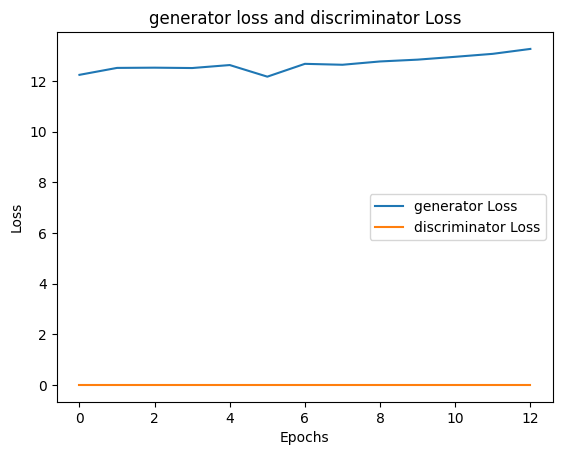

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(g_loss_epoch, label='generator Loss')
plt.plot(d_loss_epoch, label='discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('generator loss and discriminator Loss')
plt.legend()
plt.show()

https://www.kaggle.com/code/meetnagadia/handwritten-digits-generator-with-a-gan

generation of handwritings